In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [2]:
batch_size = 32
img_shape = 224

In [3]:
project_dir = '.'

In [4]:
#Converte as imagens para arrays, normaliza os dados, e aplica data augmentation para aumentar a quantidade de ruído e exemplos
#Convert image to array, normalize the data, and apply data augmentation to generate more noise and samples
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      validation_split=0.2,
      fill_mode='nearest')


train_data = image_gen.flow_from_directory(batch_size=batch_size,
                                                 directory=f"{project_dir}\\dataset\\raw-img",
                                                 shuffle=True,
                                                 target_size=(img_shape,img_shape),
                                                 class_mode='categorical',
                                                 subset='training')

valid_data = image_gen.flow_from_directory(batch_size=batch_size,
                                                 directory=f"{project_dir}\\dataset\\raw-img",
                                                 shuffle=True,
                                                 target_size=(img_shape,img_shape),
                                                 class_mode='categorical',
                                                 subset='validation')

Found 11560 images belonging to 10 classes.
Found 2890 images belonging to 10 classes.


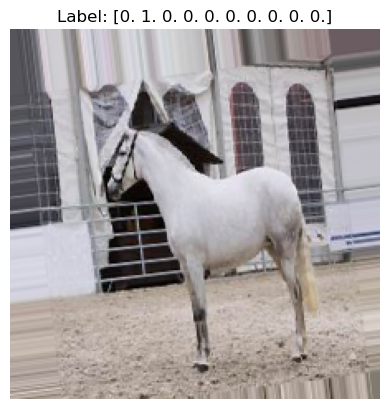

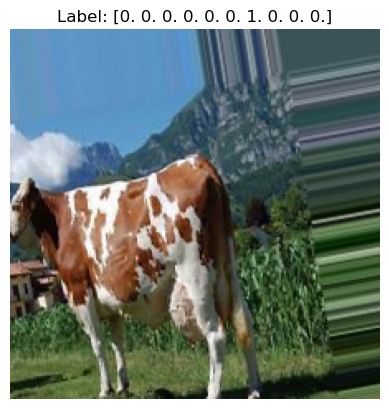

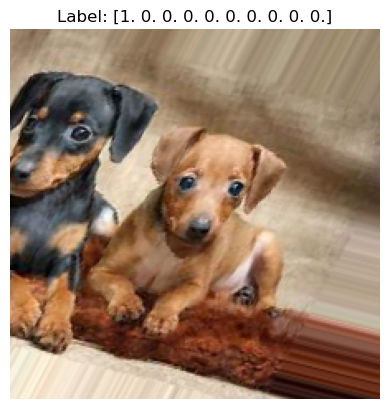

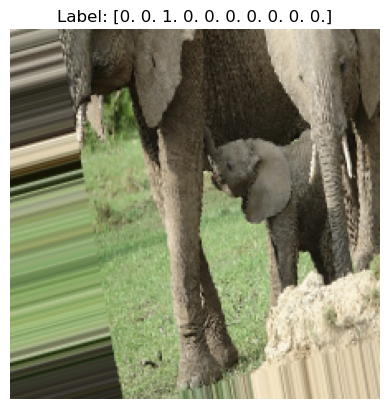

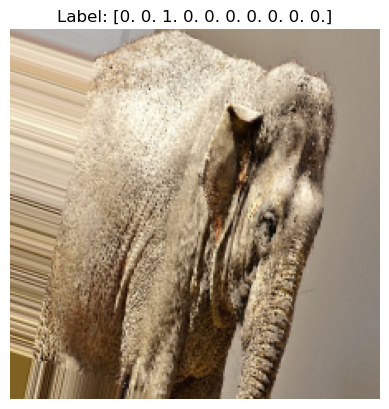

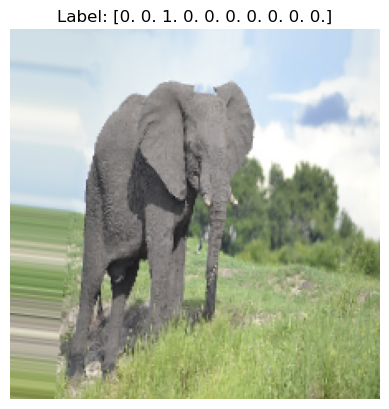

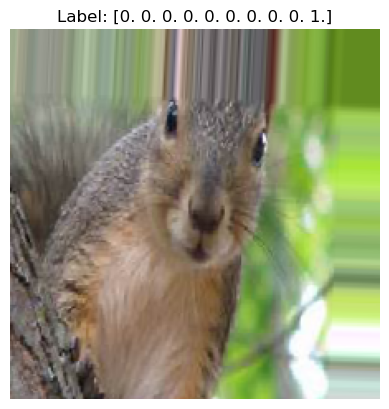

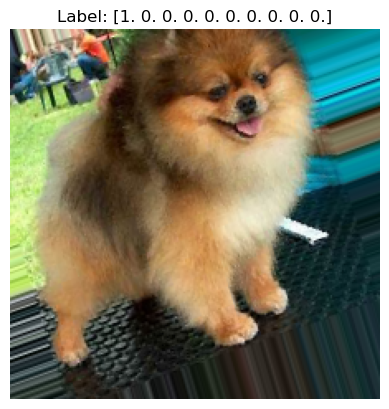

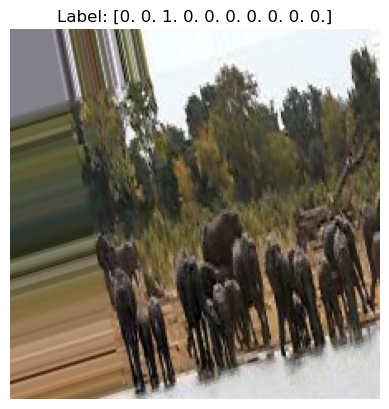

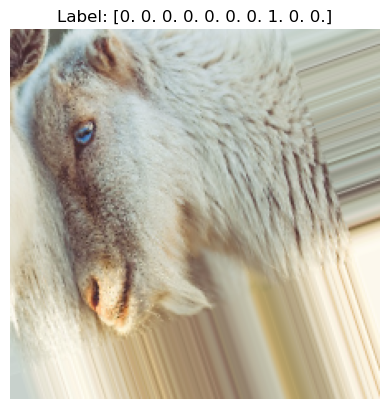

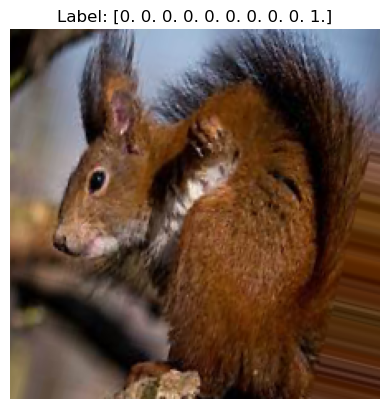

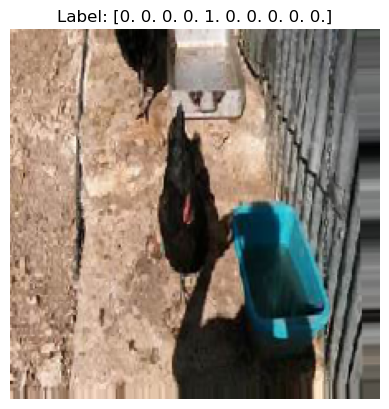

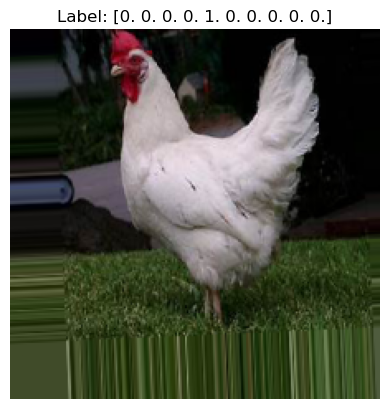

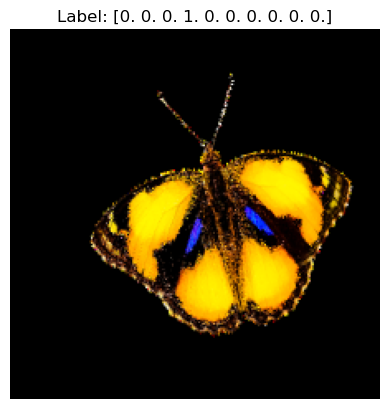

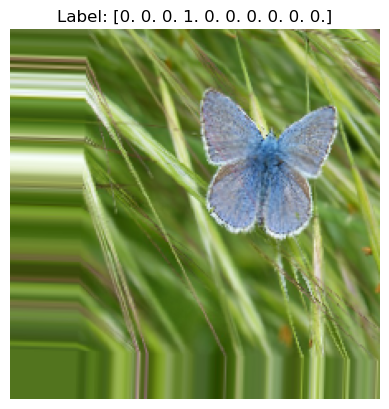

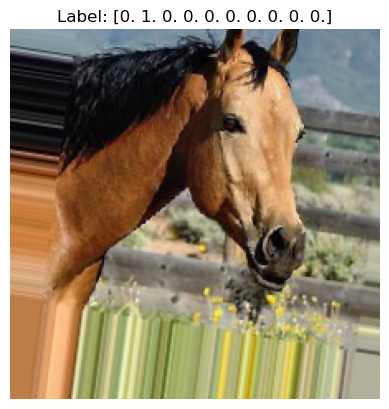

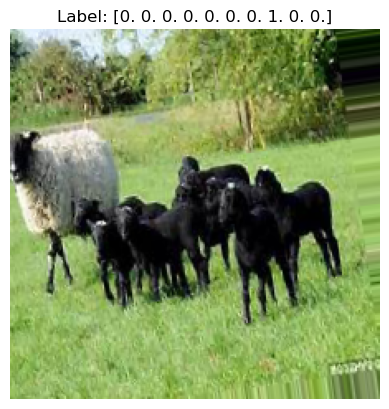

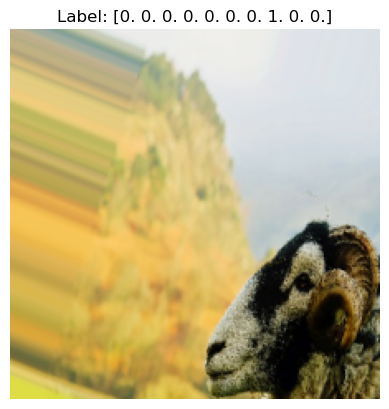

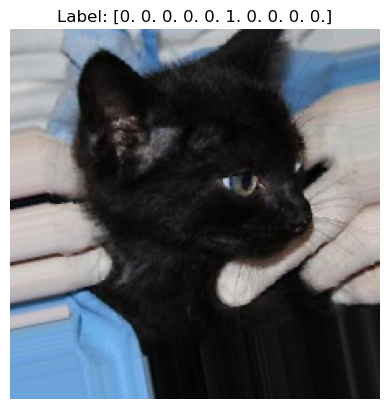

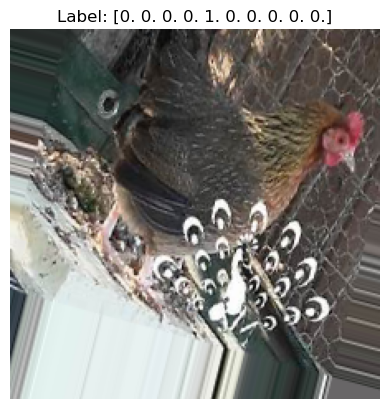

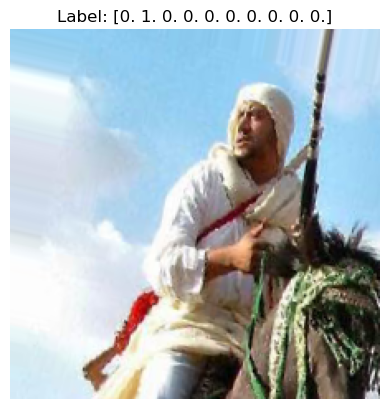

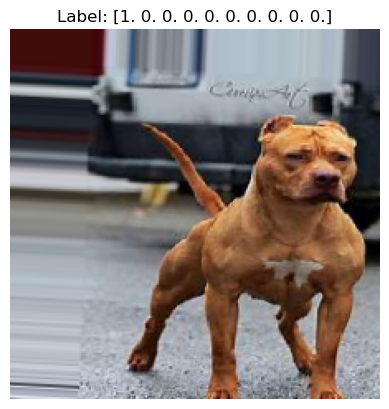

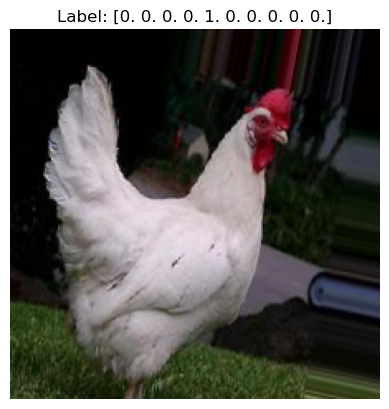

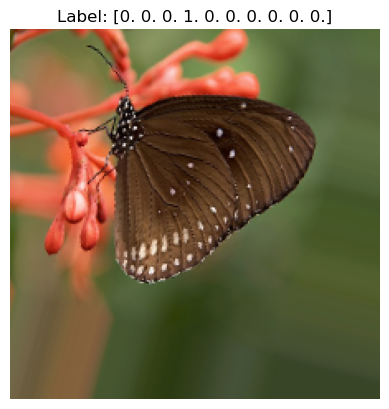

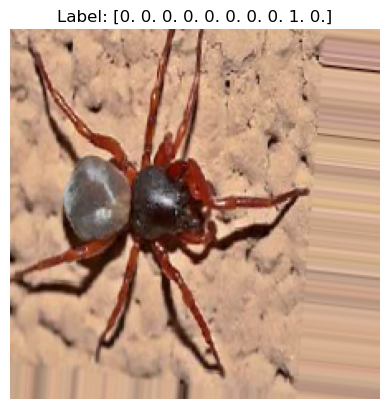

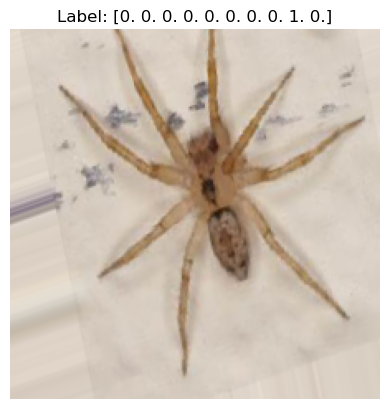

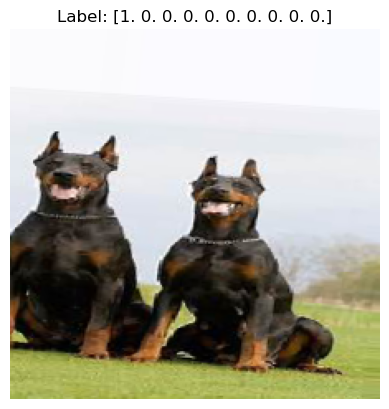

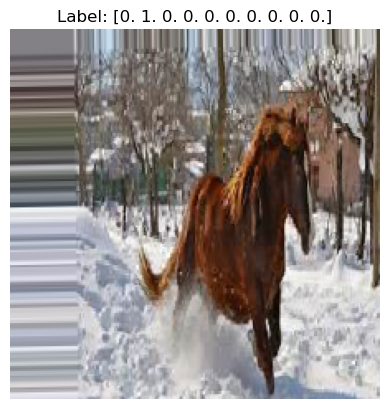

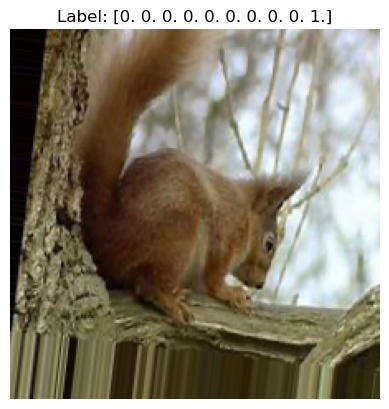

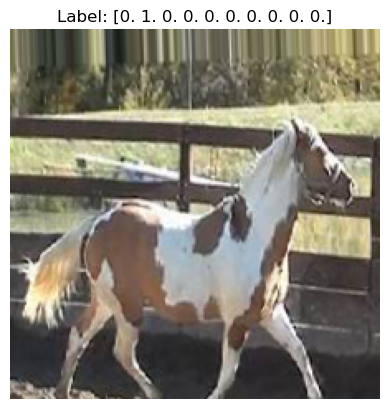

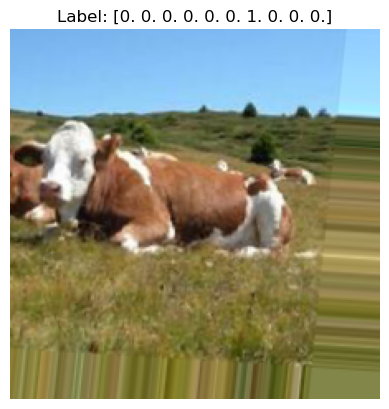

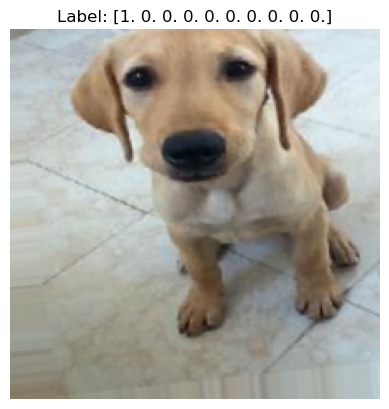

In [6]:
images, labels = next(train_data)
for i in range(len(images)):
     plt.imshow(images[i])
     plt.title(f'Label: {labels[i]}')
     plt.axis('off')
     plt.show()

In [6]:
train_data.class_indices

{'cane': 0,
 'cavallo': 1,
 'elefante': 2,
 'farfalla': 3,
 'gallina': 4,
 'gatto': 5,
 'mucca': 6,
 'pecora': 7,
 'ragno': 8,
 'scoiattolo': 9}

In [8]:
#Esse código foi usado para deixar todas as classes com a mesma quantidade de exemplos
#This code was created to make all classes have the same ammount of samples
dir_path = r"dataset\raw-img"
samples_counter = []
for path in os.listdir(dir_path):
    counter = 0
    for image in os.listdir(f"{dir_path}\{path}"):
        counter += 1
        #Descomente o if e coloque o valor desejado de exemplos para cada classe
        #Uncomment below if you want to reduce the number of samples of each class (change to the wished number)
        #if counter >= 1446:
        #    os.remove(f"{dir_path}\{path}\{image}")
    samples_counter.append({"animal": path, "number": counter})

print(sorted(samples_counter, key=lambda k:~k["number"]))

[{'animal': 'cane', 'number': 1445}, {'animal': 'cavallo', 'number': 1445}, {'animal': 'elefante', 'number': 1445}, {'animal': 'farfalla', 'number': 1445}, {'animal': 'gallina', 'number': 1445}, {'animal': 'gatto', 'number': 1445}, {'animal': 'mucca', 'number': 1445}, {'animal': 'pecora', 'number': 1445}, {'animal': 'ragno', 'number': 1445}, {'animal': 'scoiattolo', 'number': 1445}]


In [9]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 10)


In [10]:
#Mais sobre o modelo no readme
#More about the model in the readme
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(train_data.class_indices), activation='softmax')
])

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 32)     128       
 hNormalization)                                                 
                                                        

In [13]:
#Cria uma callback para manipular a taxa de aprendizado de forma decrescente durante o treinamento
#Create a exponential decay callback to manipulate learning rate during training
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=450,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [14]:
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [15]:
#Create a callback to save checkpoints during training, using info about the training in the name of the file
#Crie uma callback para salvar checkpoints durante o treinamento, usando informações sobre o treinamento no nome do arquivo.
from datetime import datetime
date_time = datetime.now().strftime("%m-%d-%Y-%H-%M-%S")

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "checkpoints/AnimalsClassifierCheckpoint-"+date_time+".EPOCH+{epoch:02d}.ACCURACY+{accuracy:2f}+VAL_ACCURACY+{val_accuracy:.2f}.h5", save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=7)

In [ ]:
epochs=30
history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=valid_data,
    callbacks=[early_stopping, model_checkpoint]
    )

Epoch 1/30
362/362 [==============================] - ETA: 0s - batch: 180.5000 - size: 31.9337 - loss: 2.2887 - accuracy: 0.2914

C:\Users\Ian\miniconda3\envs\tf\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


362/362 [==============================] - 256s 697ms/step - batch: 180.5000 - size: 31.9337 - loss: 2.2887 - accuracy: 0.2914 - val_loss: 2.9437 - val_accuracy: 0.1464
Epoch 2/30
362/362 [==============================] - 107s 297ms/step - batch: 180.5000 - size: 31.9337 - loss: 1.6967 - accuracy: 0.4010 - val_loss: 3.0655 - val_accuracy: 0.2014
Epoch 3/30
362/362 [==============================] - 104s 288ms/step - batch: 180.5000 - size: 31.9337 - loss: 1.5162 - accuracy: 0.4651 - val_loss: 1.9738 - val_accuracy: 0.3519
Epoch 4/30
362/362 [==============================] - 105s 289ms/step - batch: 180.5000 - size: 31.9337 - loss: 1.4097 - accuracy: 0.5042 - val_loss: 1.8657 - val_accuracy: 0.3875
Epoch 5/30
362/362 [==============================] - 105s 291ms/step - batch: 180.5000 - size: 31.9337 - loss: 1.3458 - accuracy: 0.5350 - val_loss: 1.4157 - val_accuracy: 0.5048
Epoch 6/30
362/362 [==============================] - 104s 288ms/step - batch: 180.5000 - size: 31.9337 - loss:

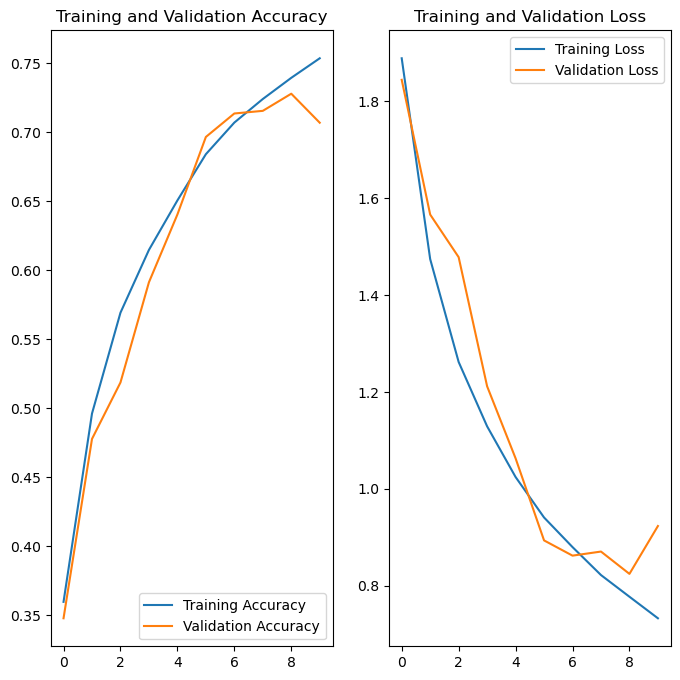

In [29]:
#Plot the accuracy and the loss of the traning and validation
#Cria gráficos para visualizar a perda e acurácia nos dados de treinamento e validação
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
#plt.savefig('./foo.png')
plt.show()